In [28]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas._libs.tslibs import dtypes, timestamps

In [29]:
model = "resnet50"
n_epochs = "2"
batch_size = "64"
save_every = "1"
log = "true"

stat_dir = "/home/gsd/andrelucena/statistics"
stat_test = "eBPFs_subset"
test_name = model + "_" + n_epochs + "_" + batch_size + "_" + save_every + "_" + log
full_test_path = stat_dir + "/" + stat_test + "/" + test_name + "/"

df = pd.read_csv(f"{full_test_path}/dstat.csv", skiprows=[0,1,2,3,4], index_col=False)
df_gpu = pd.read_csv(f"{full_test_path}/gpu.csv", dtype={"utilization.gpu": float}, index_col=False)

In [30]:

print(df.head())
print(df_gpu.head())

             time    usr     sys     idl    wai  stl          read  \
0  04-11 21:05:58  2.528   0.919  92.336  4.217    0  1.755277e+07   
1  04-11 21:05:59  7.236  69.994  15.471  7.299    0  7.938048e+06   
2  04-11 21:06:00  2.436  89.382   6.996  1.187    0  1.713357e+07   
3  04-11 21:06:01  2.376  91.432   5.191  1.001    0  2.124186e+07   
4  04-11 21:06:02  3.246  86.891   8.614  1.248    0  8.007680e+06   

         writ  read.1  writ.1  recv  send        used         free   buff  \
0  154141.098   472.6   2.998     0     0  1026441216  11436027904  12288   
1   36864.000   881.0   5.000  1680     0  1511407616  10947399680  12288   
2       0.000   998.0   0.000  1620     0  1624764416  10823536640  12288   
3       0.000   966.0   0.000  1740     0  1718489088  10717736960  12288   
4       0.000   668.0   0.000  1560     0  1787633664  10643419136  12288   

         cach       in        out  
0  2668253184  6342.49  13043.337  
1  2671915008     0.00      0.000  
2  26824

In [31]:

# df_gpu.drop(columns=['name', 'pci.bus_id'], inplace=True)
# rename columns
df.rename(columns={
'read':'read_io_total',
'writ':'write_io_total',
'time':'system_time',
'usr':'usr_cpu_usage',
'sys':'sys_cpu_usage',
'idl':'idl_cpu_usage',
'wai':'wai_cpu_usage',
'stl':'stl_cpu_usage',
'read.1':'read_dsk_total',
'writ.1':'writ_dsk_total',
'used':'used_memory',
'free':'free_memory',
'buff':'buff_memory',
'cach':'cach_memory',
'recv':'recv_net_total',
'send':'send_net_total',
'in':'in_paging',
'out':'out_paging'}, inplace=True)

df_gpu.rename(columns={
' temperature.gpu':'temperature_gpu',
' utilization.gpu [%]':'utilization_gpu',
' utilization.memory [%]':'utilization_memory',
' memory.total [MiB]':'memory_total',
' memory.free [MiB]':'memory_free',
' memory.used [MiB]':'memory_used'}, inplace=True)

In [32]:
print(df.head())
print(df_gpu.head())

      system_time  usr_cpu_usage  sys_cpu_usage  idl_cpu_usage  wai_cpu_usage  \
0  04-11 21:05:58          2.528          0.919         92.336          4.217   
1  04-11 21:05:59          7.236         69.994         15.471          7.299   
2  04-11 21:06:00          2.436         89.382          6.996          1.187   
3  04-11 21:06:01          2.376         91.432          5.191          1.001   
4  04-11 21:06:02          3.246         86.891          8.614          1.248   

   stl_cpu_usage  read_io_total  write_io_total  read_dsk_total  \
0              0   1.755277e+07      154141.098           472.6   
1              0   7.938048e+06       36864.000           881.0   
2              0   1.713357e+07           0.000           998.0   
3              0   2.124186e+07           0.000           966.0   
4              0   8.007680e+06           0.000           668.0   

   writ_dsk_total  recv_net_total  send_net_total  used_memory  free_memory  \
0           2.998              

In [33]:
# Totals

print(f"Read IO Total: {df['read_io_total'].sum():,}")
print(f"Write IO Total: {df['write_io_total'].sum():,}")
print(f"Read Disk Total: {df['read_dsk_total'].sum():,}")
print(f"Write Disk Total: {df['writ_dsk_total'].sum():,}")
print(f"Used Memory: {df['used_memory'].sum():,}")
print(f"Free Memory: {df['free_memory'].sum():,}")
print(f"Buffer Memory: {df['buff_memory'].sum():,}")
print(f"Cache Memory: {df['cach_memory'].sum():,}")
print(f"Receive Net Total: {df['recv_net_total'].sum():,}")
print(f"Send Net Total: {df['send_net_total'].sum():,}")
print()
print (f"Total GPU Utilization Memory (%): {df_gpu['utilization_memory'].sum():,}")
print (f"Total GPU Memory Total (MiB): {df_gpu['memory_total'].sum():,}")
print (f"Total GPU Memory Free (MiB): {df_gpu['memory_free'].sum():,}")
print (f"Total GPU Memory Used (MiB): {df_gpu['memory_used'].sum():,}")

Read IO Total: 128,193,910,143.993
Write IO Total: 665,934,365.098
Read Disk Total: 3,556,289.6
Write Disk Total: 9,735.998
Used Memory: 34,094,263,447,552
Free Memory: 1,552,820,109,312
Buffer Memory: 41,177,088
Cache Memory: 17,545,457,582,080
Receive Net Total: 5,359,257
Send Net Total: 19,771

Total GPU Utilization Memory (%): 253,209
Total GPU Memory Total (MiB): 27,410,432
Total GPU Memory Free (MiB): 4,846,126
Total GPU Memory Used (MiB): 21,219,207


In [35]:
# Means

print(f"Read IO Average: {df['read_io_total'].mean():,}")
print(f"Write IO Average: {df['write_io_total'].mean():,}")
print(f"Read Disk Average: {df['read_dsk_total'].mean():,}")
print(f"Write Disk Average: {df['writ_dsk_total'].mean():,}")
print(f"Used Memory Average: {df['used_memory'].mean():,}")
print(f"Free Memory Average: {df['free_memory'].mean():,}")
print(f"Buffer Memory Average: {df['buff_memory'].mean():,}")
print(f"Cache Memory Average: {df['cach_memory'].mean():,}")
print(f"Receive Net Average: {df['recv_net_total'].mean():,}")
print(f"Send Net Average: {df['send_net_total'].mean():,}")
print(f"User CPU Usage Average: {df['usr_cpu_usage'].mean():,}")
print(f"System CPU Usage Average: {df['sys_cpu_usage'].mean():,}")
print(f"Idle CPU Usage Average: {df['idl_cpu_usage'].mean():,}")
print(f"Wait CPU Usage Average: {df['wai_cpu_usage'].mean():,}")
print()
print (f"GPU Temperature Average: {df_gpu['temperature_gpu'].mean():,}")
print (f"GPU Utilization Average (%): {df_gpu['utilization_gpu'].mean():,}")
print (f"GPU Utilization Memory Average (%): {df_gpu['utilization_memory'].mean():,}")
print (f"GPU Memory Total Average (MiB): {df_gpu['memory_total'].mean():,}")
print (f"GPU Memory Free Average (MiB): {df_gpu['memory_free'].mean():,}")
print (f"GPU Memory Used Average (MiB): {df_gpu['memory_used'].mean():,}")

Read IO Average: 38,255,419.320797674
Write IO Average: 198,727.05613190093
Read Disk Average: 1,061.262190390928
Write Disk Average: 2.9054007758877947
Used Memory Average: 10,174,354,953.014622
Free Memory Average: 463,390,065.44673234
Buffer Memory Average: 12,288.0
Cache Memory Average: 5,235,887,073.136377
Receive Net Average: 1,599.3008057296329
Send Net Average: 5.900029841838257
User CPU Usage Average: 6.804612354521039
System CPU Usage Average: 5.662397493285586
Idle CPU Usage Average: 82.49128767532082
Wait CPU Usage Average: 5.041737093404954

GPU Temperature Average: 83.99043634190078
GPU Utilization Average (%): 99.6249252839211
GPU Utilization Memory Average (%): 75.67513448894202
GPU Memory Total Average (MiB): 8,192.0
GPU Memory Free Average (MiB): 1,448.3341303048417
GPU Memory Used Average (MiB): 6,341.663777644949


In [36]:
# Max and Min values
print(f"Max Read IO: {df['read_io_total'].max():,} ; Min Read IO: {df['read_io_total'].min():,}")
print(f"Max Write IO: {df['write_io_total'].max():,} ; Min Write IO: {df['write_io_total'].min():,}")
print(f"Max Read Disk: {df['read_dsk_total'].max():,} ; Min Read Disk: {df['read_dsk_total'].min():,}")
print(f"Max Write Disk: {df['writ_dsk_total'].max():,} ; Min Write Disk: {df['writ_dsk_total'].min():,}")
print(f"Max Used Memory: {df['used_memory'].max():,} ; Min Used Memory: {df['used_memory'].min():,}")
print(f"Max Free Memory: {df['free_memory'].max():,} ; Min Free Memory: {df['free_memory'].min():,}")
print(f"Max Buffer Memory: {df['buff_memory'].max():,} ; Min Buffer Memory: {df['buff_memory'].min():,}")
print(f"Max Cache Memory: {df['cach_memory'].max():,} ; Min Cache Memory: {df['cach_memory'].min():,}")
print(f"Max Receive Net: {df['recv_net_total'].max():,} ; Min Receive Net: {df['recv_net_total'].min():,}")
print(f"Max Send Net: {df['send_net_total'].max():,} ; Min Send Net: {df['send_net_total'].min():,}")
print(f"Max User CPU Usage: {df['usr_cpu_usage'].max():,} ; Min User CPU Usage: {df['usr_cpu_usage'].min():,}")
print(f"Max System CPU Usage: {df['sys_cpu_usage'].max():,} ; Min System CPU Usage: {df['sys_cpu_usage'].min():,}")
print(f"Max Idle CPU Usage: {df['idl_cpu_usage'].max():,} ; Min Idle CPU Usage: {df['idl_cpu_usage'].min():,}")
print(f"Max Wait CPU Usage: {df['wai_cpu_usage'].max():,} ; Min Wait CPU Usage: {df['wai_cpu_usage'].min():,}")
print()
print (f"Max GPU Temperature: {df_gpu['temperature_gpu'].max():,} ; Min GPU Temperature: {df_gpu['temperature_gpu'].min():,}")
print (f"Max GPU Utilization (%): {df_gpu['utilization_gpu'].max():,} ; Min GPU Utilization: {df_gpu['utilization_gpu'].min():,}")
print (f"Max GPU Utilization Memory (MiB): {df_gpu['utilization_memory'].max():,} ; Min GPU Utilization Memory (MiB): {df_gpu['utilization_memory'].min():,}")
print (f"Max GPU Memory Total (MiB): {df_gpu['memory_total'].max():,} ; Min GPU Memory Total (MiB): {df_gpu['memory_total'].min():,}")
print (f"Max GPU Memory Free (MiB): {df_gpu['memory_free'].max():,} ; Min GPU Memory Free (MiB): {df_gpu['memory_free'].min():,}")
print (f"Max GPU Memory Used (MiB): {df_gpu['memory_used'].max():,} ; Min GPU Memory Used (MiB): {df_gpu['memory_used'].min():,}")

Max Read IO: 251,703,296.0 ; Min Read IO: 0.0
Max Write IO: 205,094,912.0 ; Min Write IO: 0.0
Max Read Disk: 11,464.0 ; Min Read Disk: 0.0
Max Write Disk: 560.0 ; Min Write Disk: 0.0
Max Used Memory: 11,891,511,296 ; Min Used Memory: 1,026,441,216
Max Free Memory: 11,436,027,904 ; Min Free Memory: 177,532,928
Max Buffer Memory: 12,288 ; Min Buffer Memory: 12,288
Max Cache Memory: 7,314,931,712 ; Min Cache Memory: 2,668,253,184
Max Receive Net: 2,362 ; Min Receive Net: 0
Max Send Net: 328 ; Min Send Net: 0
Max User CPU Usage: 35.772 ; Min User CPU Usage: 2.376
Max System CPU Usage: 91.432 ; Min System CPU Usage: 0.919
Max Idle CPU Usage: 93.433 ; Min Idle CPU Usage: 5.191
Max Wait CPU Usage: 46.746 ; Min Wait CPU Usage: 0.0

Max GPU Temperature: 85 ; Min GPU Temperature: 65
Max GPU Utilization (%): 100 ; Min GPU Utilization: 0
Max GPU Utilization Memory (MiB): 77 ; Min GPU Utilization Memory (MiB): 0
Max GPU Memory Total (MiB): 8,192 ; Min GPU Memory Total (MiB): 8,192
Max GPU Memory Fr

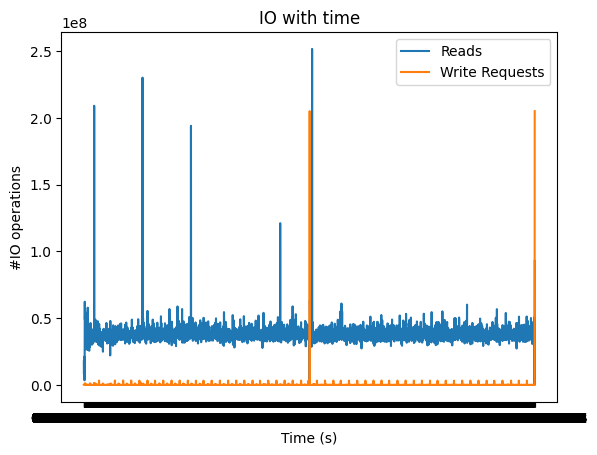

In [37]:
# plots IO with time
plt.figure()
plt.plot(df['system_time'], df['read_io_total'], label='Reads')
plt.plot(df['system_time'], df['write_io_total'], label='Write Requests')
plt.xlabel('Time ')
plt.ylabel('#IO operations')
plt.title('IO with time')
plt.legend()
plt.show()

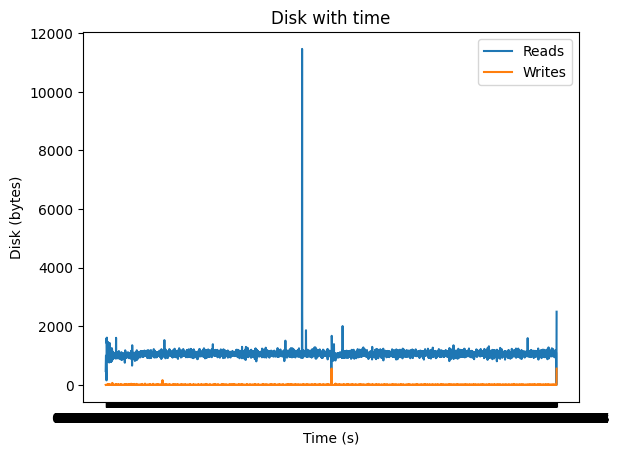

In [38]:
# plots Disk with time
plt.figure()
plt.plot(df['system_time'], df['read_dsk_total'], label='Reads')
plt.plot(df['system_time'], df['writ_dsk_total'], label='Writes')
plt.xlabel('Time ')
plt.ylabel('Disk (bytes)')
plt.title('Disk with time')
plt.legend()
plt.show()

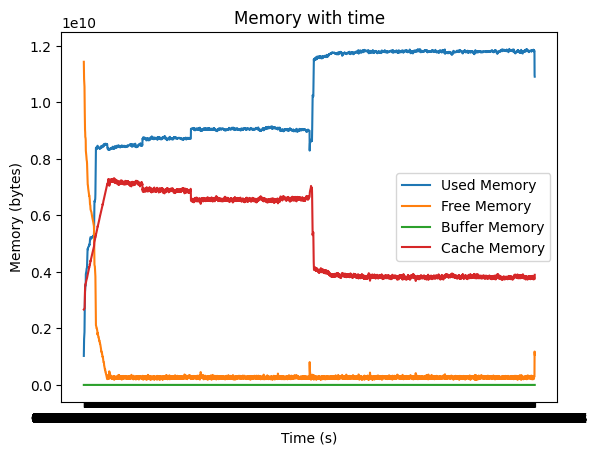

In [39]:
# plots Memory with time
plt.figure()
plt.plot(df['system_time'], df['used_memory'], label='Used Memory')
plt.plot(df['system_time'], df['free_memory'], label='Free Memory')
plt.plot(df['system_time'], df['buff_memory'], label='Buffer Memory')
plt.plot(df['system_time'], df['cach_memory'], label='Cache Memory')
plt.xlabel('Time ')
plt.ylabel('Memory (bytes)')
plt.title('Memory with time')
plt.legend()
plt.show()

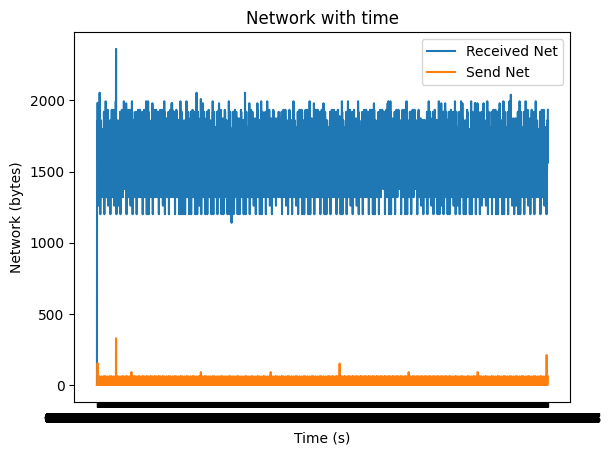

In [40]:
# plots Network with time
plt.figure()
plt.plot(df['system_time'], df['recv_net_total'], label='Received Net')
plt.plot(df['system_time'], df['send_net_total'], label='Send Net')
plt.xlabel('Time ')
plt.ylabel('Network (bytes)')
plt.title('Network with time')
plt.legend()
plt.show()

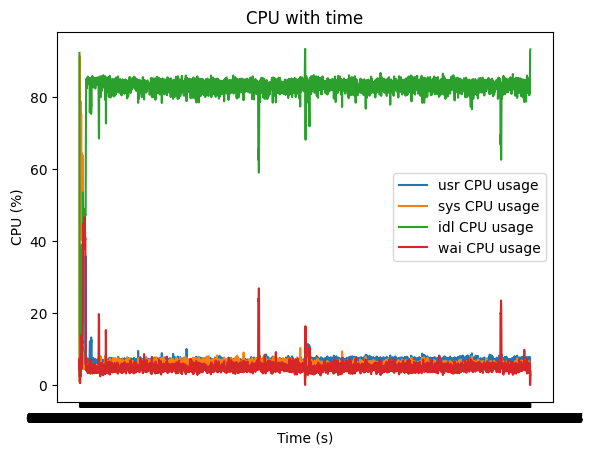

In [41]:
# plots CPU with time
plt.figure()
plt.plot(df['system_time'], df['usr_cpu_usage'], label='usr CPU usage')
plt.plot(df['system_time'], df['sys_cpu_usage'], label='sys CPU usage')
plt.plot(df['system_time'], df['idl_cpu_usage'], label='idl CPU usage')
plt.plot(df['system_time'], df['wai_cpu_usage'], label='wai CPU usage')
plt.xlabel('Time ')
plt.ylabel('CPU (%)')
plt.title('CPU with time')
plt.legend()
plt.show()

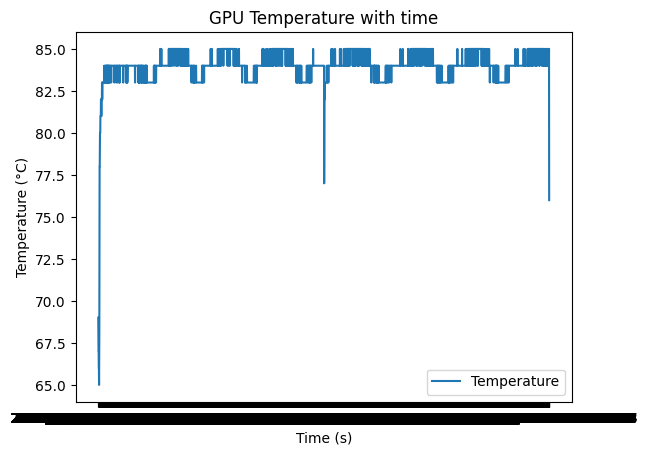

In [42]:
# plots gpu temperature with time
plt.figure()
plt.plot(df_gpu['timestamp'], df_gpu['temperature_gpu'], label='Temperature')
plt.xlabel('Time ')
plt.ylabel('Temperature (°C)')
plt.title('GPU Temperature with time')
plt.legend()
plt.show()

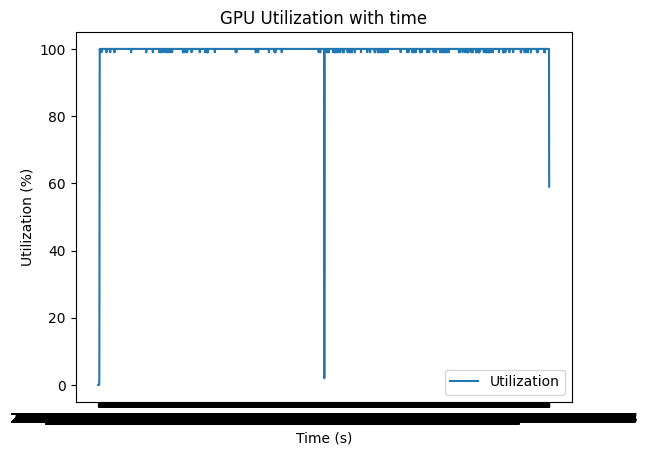

In [43]:
# plots gpu utilization with time
plt.figure()
plt.plot(df_gpu['timestamp'], df_gpu['utilization_gpu'], label='Utilization')
plt.xlabel('Time ')
plt.ylabel('Utilization (%)')
plt.title('GPU Utilization with time')
plt.legend()
plt.show()

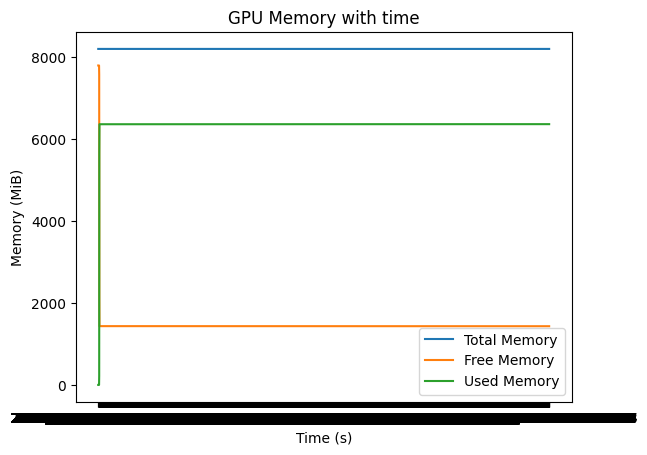

In [44]:
# plots gpu memory with time
plt.figure()
plt.plot(df_gpu['timestamp'], df_gpu['memory_total'], label='Total Memory')
plt.plot(df_gpu['timestamp'], df_gpu['memory_free'], label='Free Memory')
plt.plot(df_gpu['timestamp'], df_gpu['memory_used'], label='Used Memory')
plt.xlabel('Time ')
plt.ylabel('Memory (MiB)')
plt.title('GPU Memory with time')
plt.legend()
plt.show()